# Summary of Learned Concepts in CAP 4630 - Training and Fine Tuning

This will look into the training and fine-tuning of neural network models.

In [0]:
import os
import zipfile

import numpy as np
%matplotlib inline
import matplotlib as mpl
from matplotlib import cm, image as mpimg, pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

## Training

### Model Fitting

The desire of a model is to not only run well on the training set, but also to make accurate predictions on the testing and validation sets. In a *good fit* model, the training sets and the testing sets both are predicted well by the model. If this is not the case, chances are the model falls into one of the two following categories:

####1. Underfitting

In this case, neither the training set nor the testing set give good results. If we look at the final epoch in the training of the model described [here](https://colab.research.google.com/drive/18sIzC0BdTvH2WJOMoye8p8fn2nj3KyjB#scrollTo=3hVVNeSElXmT "Neural Networks - Python Notebook"), we can see how both the **accuracy** and the **val_accuracy** are both low (both only accurate around 35% of the time). 

```
Epoch 5/5
1600/1600 [==============================] - 3s 2ms/step - loss: 1.7351 - accuracy: 0.3756 - val_loss: 1.7618 - val_accuracy: 0.3500
```

There are a few causes of underfitting, but the main causes are the following:
* Too simple of a model.
* Bad data.
* Not enough time given to the model to learn.

In the case of this model, it was way too simple to be able to discern the ten different classes. Though, notice how it must have learned *something*, as a random guess of a class would have only yielded a 10% accuracy, on average. Also, we used an extremely small amount of training and testing data, which was also a limiting factor.

#### Overfitting

On the other hand, a model is said to be overfitted when it yields extremely high training accuracy, but a low validation accuracy. The model did not generalize the features of the training set, but instead just brute forced the members of the training set into its "memory". Thus, when faced with new data, it cannot properly distingush it. Let's use the same model to show this:

In [0]:
# Constructs the neural network model according to the specifications given
model = models.Sequential()

# Adds the layers to the model. Also specifies the size of the input data on the first layer
model.add(layers.Conv2D(32, (5, 5), activation='relu', strides=1,
                        padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2), strides=2))

model.add(layers.Conv2D(32, (5, 5), activation='relu', strides=1))
model.add(layers.MaxPool2D((2, 2), strides=2))

model.add(layers.Conv2D(64, (5, 5), activation='relu', strides=1))
model.add(layers.MaxPool2D((2, 2), strides=2))

# Flatten the layers before adding final fully-connected layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compiles the model using cross entropy (categorial as multi-class)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

... and train it on CIFAR-10...

In [0]:
# Loads in CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Normalize the data (Easier training)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255
# Flattens the labels
y_train = y_train.flatten()
y_test = y_test.flatten()
# Defines the size of each set
# (Note: normally, these subsets would be chosen randomly, but this only uses
# the first n elements from each set for simplicity)
train_size = 500
test_size = 100

history  = model.fit(x_train[:train_size], y_train[:train_size], epochs=20,
                     validation_data=(x_test[:test_size], y_test[:test_size]))

Train on 500 samples, validate on 100 samples
Epoch 1/20
500/500 [==============================] - 1s 2ms/step - loss: 2.3086 - accuracy: 0.1100 - val_loss: 2.2945 - val_accuracy: 0.0600
Epoch 2/20
500/500 [==============================] - 1s 2ms/step - loss: 2.2661 - accuracy: 0.1360 - val_loss: 2.2625 - val_accuracy: 0.1400
Epoch 3/20
500/500 [==============================] - 1s 2ms/step - loss: 2.2237 - accuracy: 0.1620 - val_loss: 2.2015 - val_accuracy: 0.0600
Epoch 4/20
500/500 [==============================] - 1s 2ms/step - loss: 2.1480 - accuracy: 0.2260 - val_loss: 2.0954 - val_accuracy: 0.3100
Epoch 5/20
500/500 [==============================] - 1s 2ms/step - loss: 2.0814 - accuracy: 0.2200 - val_loss: 2.1878 - val_accuracy: 0.0900
Epoch 6/20
500/500 [==============================] - 1s 2ms/step - loss: 1.9911 - accuracy: 0.2700 - val_loss: 1.9829 - val_accuracy: 0.3300
Epoch 7/20
500/500 [==============================] - 1s 2ms/step - loss: 1.9730 - accuracy: 0.3040 - 

Besides viewing the last epoch, we can look at the trajectory of the training and validation accuracy and loss over all of the epochs:

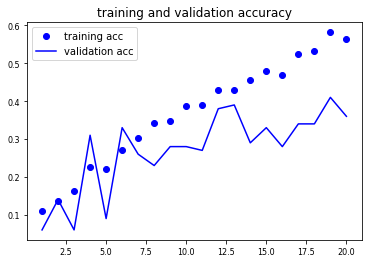

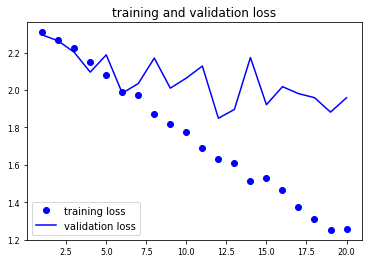

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This clearly shows how the model did not suffiecntly learn the features of the classes in CIFAR-10.

#### Good Fit

Let's look at a model that does not overfit on its data.

The [MNIST dataset](https://keras.io/datasets/ "Datasets - Keras") is a set of handwritten numbers:

In [0]:
# Loads in the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255

This [blog post](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d "Image Classfication - Towards Data Science") presents the following model to learn what the numbers are:

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation=tf.nn.relu))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10,activation=tf.nn.softmax))

Let's train this model.

In [0]:
# Defines the size of each set
# (Note: normally, these subsets would be chosen randomly, but this only uses
# the first n elements from each set for simplicity)
train_size = 8000
test_size = 2000

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
history = model.fit(x=x_train[:train_size],y=y_train[:train_size], epochs=5,
                    validation_data=(x_test[:test_size], y_test[:test_size]))

Train on 8000 samples, validate on 2000 samples
Epoch 1/5
8000/8000 [==============================] - 5s 663us/step - loss: 0.0084 - accuracy: 0.9981 - val_loss: 0.2721 - val_accuracy: 0.9555
Epoch 2/5
8000/8000 [==============================] - 5s 629us/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.2838 - val_accuracy: 0.9570
Epoch 3/5
8000/8000 [==============================] - 5s 639us/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.2612 - val_accuracy: 0.9575
Epoch 4/5
8000/8000 [==============================] - 5s 636us/step - loss: 0.0126 - accuracy: 0.9966 - val_loss: 0.2523 - val_accuracy: 0.9605
Epoch 5/5
8000/8000 [==============================] - 5s 635us/step - loss: 0.0077 - accuracy: 0.9970 - val_loss: 0.2460 - val_accuracy: 0.9585


... and view the accuracy and loss over the epochs:

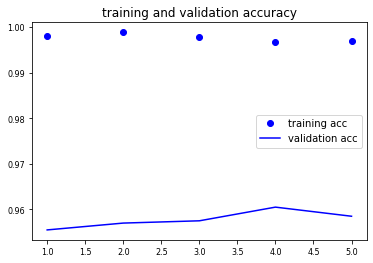

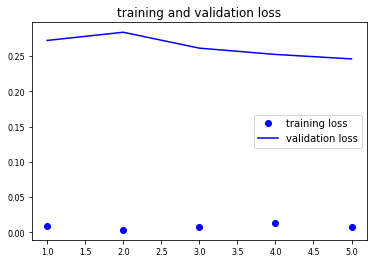

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

Notice although the data seems relatively far apart, that is only due to the scaling of the graph. In reality the validation set is very close to the training set, thus the model actually generalized well.

## Fine-Tuning

Training a network from scratch can take an extremely long time; some networks can take days to train on large datasets. Is there any way to reduce this time? Well, there are many times where the problem wanted to be modeled (eg. image classification) has already been done extensively by an existing network. So, why not take advantage of the effort and time that was used to create that network?

Take image classfication, for an example. If you wanted to train a model that distingushes between cats and dogs, you can always make your own network and train it. However, there are already networks that have been made to distinguish thousands of different classes in images (*VGG16/19*, *Xception*, etc.). Specifically, these network architectures have been trained on massive datasets, such as *ImageNet*.

The models may not have the fidelity of classification for the specific classes that is part of the problem. There is, however, a process that uses the backbone of the network, and makes slight adjustments to the end of the networks (where most of the abstract information is stored). This is what the process of fine-tuning is.

There are two major steps in fine-tuning: first is the train a new *classifier* on the original network, known as the *convolutional base*, without altering it. The second step is to pick a number of layers from the end of the conv base and reopen it for training. A smaller learning rate is used, thus making sure to only tune the network to work better with the new inputs, rather than altering the entire structure. This is why the process is known as fine-tuning.

### Example

Let's implement the example of fine-tuning cats and dogs.
This will use MobileNet as the convolutional base.

Gets the images of cats and dogs:

In [7]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Creates a training and validation set
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

--2020-04-24 21:39:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   164MB/s    in 0.4s    

2020-04-24 21:39:30 (164 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Loads the convolutional base and freezes it:

In [8]:
from keras.applications import MobileNet

conv_base = MobileNet(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

conv_base.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Concatenates the conv base with fully connected layers (the classifier):

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

Trains the model with the frozen conv base:

In [16]:
# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=5
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/15
10/10 [==============================] - 12s 1s/step - loss: 1.5332 - acc: 0.5400 - val_loss: 0.7278 - val_acc: 0.7700
Epoch 2/15
10/10 [==============================] - 9s 933ms/step - loss: 1.2757 - acc: 0.5650 - val_loss: 0.4361 - val_acc: 0.8200
Epoch 3/15
10/10 [==============================] - 9s 941ms/step - loss: 1.2910 - acc: 0.5450 - val_loss: 0.3612 - val_acc: 0.8900
Epoch 4/15
10/10 [==============================] - 9s 934ms/step - loss: 0.9309 - acc: 0.6250 - val_loss: 0.1694 - val_acc: 0.8400
Epoch 5/15
10/10 [==============================] - 9s 936ms/step - loss: 1.1066 - acc: 0.5900 - val_loss: 0.2489 - val_acc: 0.8300
Epoch 6/15
10/10 [==============================] - 9s 943ms/step - loss: 1.1504 - acc: 0.6150 - val_loss: 0.3869 - val_acc: 0.8800
Epoch 7/15
10/10 [==============================] - 9s 939ms/step - loss: 0.8031 - acc: 0.6500 - val_loss: 0.1962 - val_acc: 0

Fine-Tunes the network:

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv_pw_12':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [18]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=5)

Epoch 1/30
10/10 [==============================] - 12s 1s/step - loss: 0.6305 - acc: 0.7600 - val_loss: 0.2277 - val_acc: 0.9200
Epoch 2/30
10/10 [==============================] - 9s 949ms/step - loss: 0.5156 - acc: 0.8100 - val_loss: 0.2696 - val_acc: 0.9100
Epoch 3/30
10/10 [==============================] - 10s 954ms/step - loss: 0.4089 - acc: 0.8100 - val_loss: 0.2379 - val_acc: 0.9300
Epoch 4/30
10/10 [==============================] - 9s 946ms/step - loss: 0.5732 - acc: 0.8300 - val_loss: 0.0965 - val_acc: 0.9300
Epoch 5/30
10/10 [==============================] - 10s 956ms/step - loss: 0.7119 - acc: 0.7250 - val_loss: 0.2949 - val_acc: 0.9400
Epoch 6/30
10/10 [==============================] - 10s 965ms/step - loss: 0.6301 - acc: 0.7550 - val_loss: 0.1328 - val_acc: 0.9600
Epoch 7/30
10/10 [==============================] - 10s 951ms/step - loss: 0.4909 - acc: 0.8100 - val_loss: 0.1540 - val_acc: 0.9600
Epoch 8/30
10/10 [==============================] - 10s 951ms/step - loss:

Displays the training and validation loss and accuracy for fine-tuning:

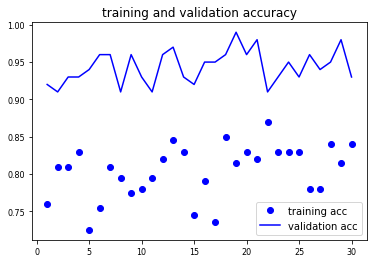

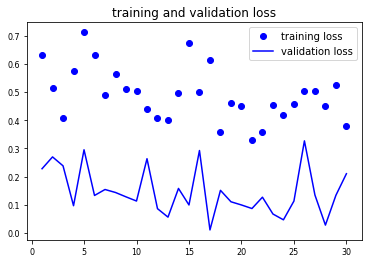

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()